# Part 1

The following code represents a simple, inefficient pattern search that might be found during EDA in a jupyter notebook.

In a separate `.py` file, refactor this code using OOP to make it more extensible and efficient.

Your object should be able to do each of the following:

1. Accept either a string or a list of words as input text to be searched for pattern matches (if a string is passed, only words in the string that match the pattern should be caught)
2. Allow for registering an arbitrary number of pattern groups to search input text
3. Allow the user to specify a specific pattern group to search the text for matches
4. Allow the user to search input text with all registered patterns and return all matches by pattern group

In [ ]:
my_words = ['dog', 'cat', 'mouse', 'bird', 'snake', 'kitten', 'puppy']

pattern_1_words = []
pattern_2_words = []

pattern_group_1 = [
	'at',
	'ou'
]

pattern_group_2 = [
	'in',
	'mo'
]

for word in my_words:
	for pat in pattern_group_1:
		if pat in word:
			pattern_1_words.append(word)
for word in my_words:
	for pat in pattern_group_2:
		if pat in word:
			pattern_2_words.append(word)

print(f"Pattern 1: {pattern_1_words}")
print(f"Pattern 2: {pattern_2_words}")

# Part 2

Writes tests for your code using `pytest`

# Part 3

Imagine your job is to help build the text processing pipeline for a machine learning model. This model takes strings, processes them into vectors, and then classifies the text as relating to one of several categories (a multiclass classifier).

The raw data that is passed into the machine learning pipeline has strings that may include descriptions of many items, including multiple items that we are seeking to classify, as well as descriptions of items that are irrelevant to our classifier. These must be separated before being passed to classifier.

As the newest member of the team, your job is to get up to speed with the data as quickly as possible, and to find opportunities to improve the text processing pipeline. Perform an EDA on the following CSV to accomplish this. Be prepared to explain what insights you learned from the data, and what approaches you might use to improve the pipeline.

Perform the analysis in this notebook, below this prompt.

# Analysis

In [231]:
## Imports ##
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors

import spacy

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

In [232]:
# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

First we'll import the csv data and take a look at it.

In [233]:
df = pd.read_csv('../data/takehome.csv', index_col='id')
df.head()

,text,added_datetime,yes_no,image_coordinates,image_url,original_id,page_number,parser_version,model_version,manual_override
id,,,,,,,,,,
462548,No plastic bags or pesticide containers .,2021-07-13 01:18:01.983,no,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 699, 'x2': 913, 'y1': 367, 'y2': 503}",NaN,NaN,NaN,NaN,NaN,NaN
462549,No paint or aerosol cans .,2021-07-13 01:18:01.983,no,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 695, 'x2': 909, 'y1': 740, 'y2': 876}",NaN,NaN,NaN,NaN,NaN,NaN
462550,Tin and aluminum food and drink cans .,2021-07-13 01:18:01.983,yes,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 224, 'x2': 438, 'y1': 771, 'y2': 907}",NaN,NaN,NaN,NaN,NaN,NaN
462551,Corrugated and non corrugated . Includes cereal - type boxes and egg cartons .,2021-07-13 01:18:01.983,yes,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 224, 'x2': 438, 'y1': 630, 'y2': 766}",NaN,NaN,NaN,NaN,NaN,NaN
462552,"Includes all colors office paper , newspapers , magazines , catalogs , envelopes with windows , and phone books .",2021-07-13 01:18:01.983,yes,"{'originalSize': {'height': 1700, 'width': 2200}, 'x1': 225, 'x2': 439, 'y1': 499, 'y2': 635}",NaN,NaN,NaN,NaN,NaN,NaN


#### There's not a lot of context in the data and most of the columns seem to be mainly null. There is a yes/no column that seems to be correlated to the text, if the text specifies a material (YES) or excludes a material (NO). So we'll keep the index column, the text column and the yes_no column. The rest of the columns need more information or context, so we'll leave them out of the analyses for now.

We check for null in the text column and drop those rows as well as the rows that won't be analyzed.

In [234]:
df.isnull().sum()

text                    3
added_datetime          0
yes_no                  0
image_coordinates     660
image_url            1000
original_id          1000
page_number          1000
parser_version        340
model_version         340
manual_override       340
dtype: int64

In [235]:
df = df[['text', 'yes_no']]
df.dropna(subset=['text'], inplace=True)
df.isnull().sum()

text      0
yes_no    0
dtype: int64

In [236]:
df.shape

(997, 2)

Now we are going to clean the text to remove unwanted characters and be able to compare word counts and do other data manipulation.

In [237]:
def clean_text(text):
    """
    Accepts a single text document and performs several regex
    substitutions in order to clean the document.
    Parameters
    ----------
    text: string
    Returns
    -------
    text: list of words
    """
    special_chars_regex = '[:?,.>$|!\'"]'
    white_spaces_regex = '[ ]{2,}'
    text = re.sub('[^a-zA-Z ]', " ", text)
    text = re.sub(special_chars_regex, " ", text)
    text = re.sub(white_spaces_regex, " ", text)
    return text

In [238]:
df['text'] = [clean_text(text) for text in df['text']]


Let's look at how many words each row contains. Makes sense that there would be a correlation between the number of materials in the classification and the number of words in the text. We'll add that data as a column and plot the histogram. We can see that the vast majority of text is under 10 words. Maybe this would be useful in the future (ie. applying different models, or manually reviewing rows with the long text).

(array([  2., 159., 196.,  71.,  62., 238.,  34.,  34.,  19.,  17.,  12.,
         12.,  11.,  12.,   7.,  10.,   7.,   9.,   4.,   8.,   6.,   5.,
          3.,   2.,   1.,   2.,   3.,   0.,   9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

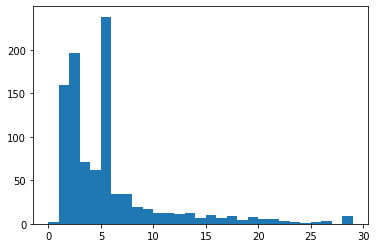

In [239]:
df['num_of_words'] = [len(text.split()) for text in df['text']]
plt.hist(df['num_of_words'],bins=range(30))

In [243]:
cv = CountVectorizer(stop_words='english', ngram_range=[1,2]) 
cv_matrix = cv.fit_transform(df['text']) 
# create document term matrix
df_dtm = pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names_out())

<BarContainer object of 10 artists>

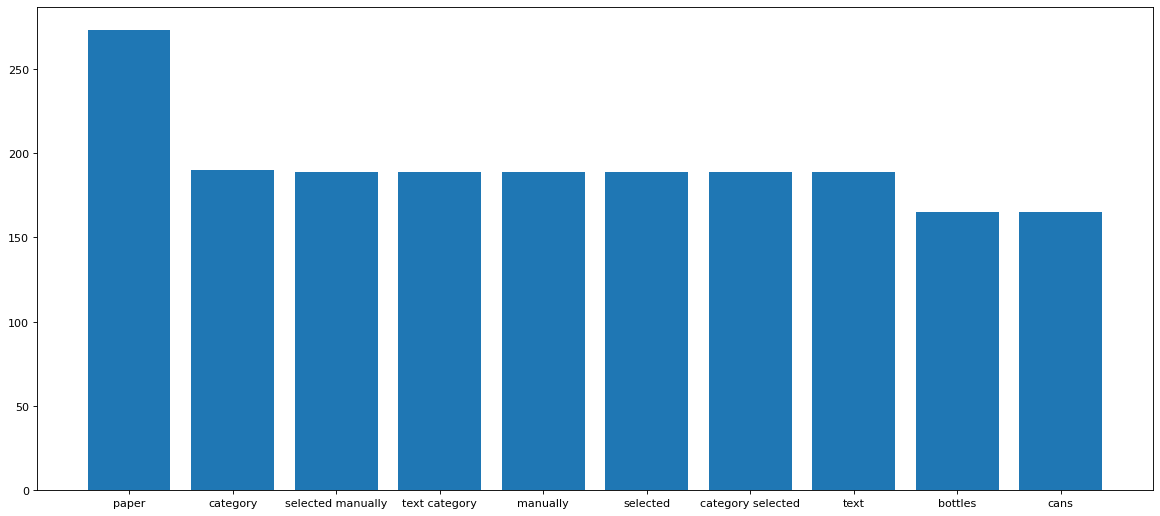

In [245]:
word_count = pd.DataFrame(index=cv.get_feature_names_out(), data=[df_dtm[feature].sum() for feature in cv.get_feature_names_out()], 
             columns=['count']).sort_values(by=['count'], axis=0, ascending=False)
plt.figure(figsize=(18, 8), dpi=80)
plt.bar(word_count[:10].index, word_count['count'][:10])

We find that 'category', 'selected manually', etc. are a large part of the word count, which is odd so we look at the rows that contain 'category':

In [194]:
[(index, text) for (index, text) in zip(df.index, df['text']) if 'category' in text]

[(462634,
  'Mixed Paper This category includes all other paper such as notebook paper Post it notes colored copy paper computer paper and white copy paper white envelopes green bar or blue bar computer paper junk mail etc Staples are OK '),
 (280510, 'No text category selected manually'),
 (280512, 'No text category selected manually'),
 (280573, 'No text category selected manually'),
 (306757, 'No text category selected manually'),
 (310641, 'No text category selected manually'),
 (280536, 'No text category selected manually'),
 (280537, 'No text category selected manually'),
 (280538, 'No text category selected manually'),
 (280539, 'No text category selected manually'),
 (280540, 'No text category selected manually'),
 (280541, 'No text category selected manually'),
 (280542, 'No text category selected manually'),
 (280543, 'No text category selected manually'),
 (280544, 'No text category selected manually'),
 (280545, 'No text category selected manually'),
 (280546, 'No text cate

We'll drop rows with 'No text category selected manually' and re-run the analysis.

In [248]:
df = df[df['text'] != 'No text category selected manually']
df.shape

(808, 3)

Re-running the analysis:

<BarContainer object of 20 artists>

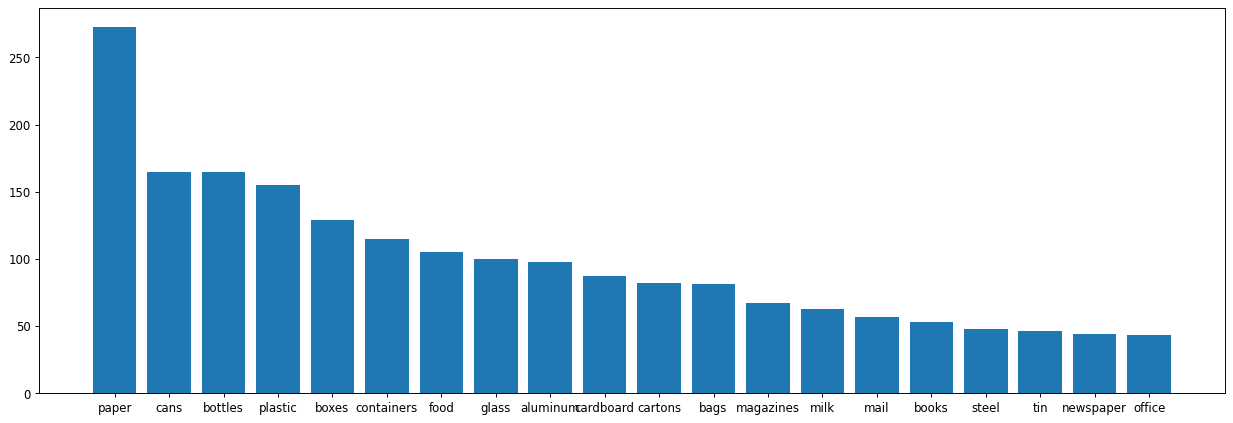

In [249]:
cv = CountVectorizer(stop_words='english') 
cv_matrix = cv.fit_transform(df['text']) 
# create document term matrix
df_dtm = pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names_out())
#Word count
word_count = pd.DataFrame(index=cv.get_feature_names_out(), data=[df_dtm[feature].sum() for feature in cv.get_feature_names_out()], 
             columns=['count']).sort_values(by=['count'], axis=0, ascending=False)
plt.figure(figsize=(18, 6), dpi=85)
plt.bar(word_count[:20].index, word_count['count'][:20])

We'll also run the word count per row again:

(array([  2., 159., 196.,  71.,  62.,  49.,  34.,  34.,  19.,  17.,  12.,
         12.,  11.,  12.,   7.,  10.,   7.,   9.,   4.,   8.,   6.,   5.,
          3.,   2.,   1.,   2.,   3.,   0.,   9.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

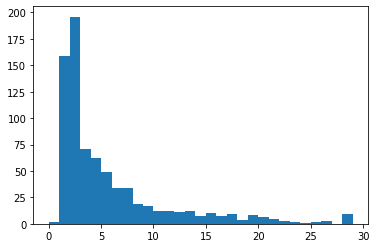

In [250]:
plt.hist(df['num_of_words'],bins=range(30))

Let's take a look at the rows with over 25 words:

In [251]:
pd.set_option('display.max_colwidth', None)
df[df['num_of_words'] > 15].head()

,text,yes_no,num_of_words
id,,,
462563,Plastics such as those from Cleaners Food containers Bleach Milk Cooking oils Pill bottles Cosmetics lotions Shampoo conditioner Soft drinks Detergents Flower pots Water or juice,yes,26
462564,Catalogs Cereal boxes Shredded paper Mail Toilet paper rolls Frozen food boxes Greeting cards Boxboard e g pop boxes,yes,19
462565,Office paper white and colored Phonebooks Corrugated cardboard Tissue boxes Snack boxes Pop and beer cartons Wrapping paper tubes Paper gift shopping bags Nut or chip canister e g Pringles,yes,30
462566,Newspaper advertisements Magazines Shoe boxes Paperback books Paper egg cartons Paper towel rolls Tissue paper Kraft paper bags Gable Top Containers Orange Juice or Milk Carton,yes,26
462567,Aluminum and metal cans foil and foil trays lids and aerosol spray cans must be empty Please,yes,17


#### We'll separate the yes and no rows in two different dataframes.

In [212]:
df_yes = df.loc[df['yes_no'] == 'yes']
df_no = df.loc[df['yes_no'] == 'no']

In [213]:
print(df_yes.shape)
print(df_no.shape)


(681, 3)
(127, 3)


Let's run the word-count analysis for df_no, it'd be interesting to see what is being excluded:

In [215]:
df_no.head(25)

,text,yes_no,num_of_words
id,,,
462548,No plastic bags or pesticide containers,no,6
462549,No paint or aerosol cans,no,5
462555,Broken glass,no,2
462556,Aerosol cans Gas cans,no,4
462557,Mirror window glass crystal drinking glass ceramics ovenware light bulbs,no,10
462558,Gift wrap,no,2
462559,Plastic grocery bags,no,3
462560,Styrofoam,no,1
462571,Shingles Ashes Chemicals Yard Waste Railroad Ties Concrete Brick Rock Dirt Large Metal Objects such as Cars Machinery Livestock Feeders Fencing etc,no,22


In [216]:
cv = CountVectorizer(stop_words='english', ngram_range=[1,2]) 
cv_matrix = cv.fit_transform(df_no['text']) 
# create document term matrix
df_dtm = pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names_out())

<BarContainer object of 20 artists>

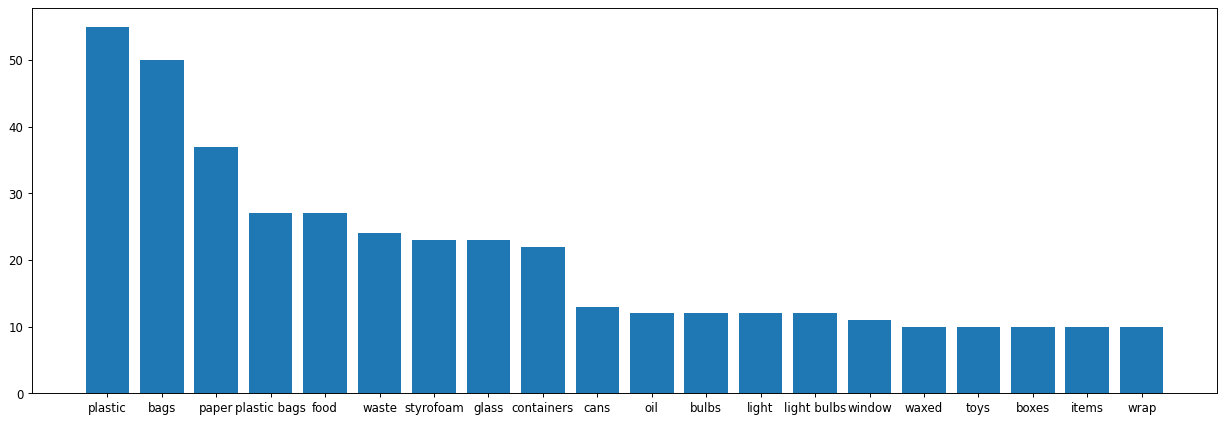

In [217]:
word_count = pd.DataFrame(index=cv.get_feature_names_out(), data=[df_dtm[feature].sum() for feature in cv.get_feature_names_out()], 
             columns=['count']).sort_values(by=['count'], axis=0, ascending=False)
plt.figure(figsize=(18, 6), dpi=85)
plt.bar(word_count[:20].index, word_count['count'][:20])

In [226]:
word_count[word_count.index.str.contains(' ')][:10]

,count
plastic bags,27
light bulbs,12
window glass,8
food waste,8
motor oil,6
waxed paper,6
wrapping paper,5
bags plastic,5
aerosol cans,5
pizza boxes,5


In [252]:
def tokenize(doc):
# run the clean_data function on the text
    text = clean_text(doc)
# Instantiatie language model
    doc = nlp(text)
    STOP_WORDS = nlp.Defaults.stop_words.union('', 'the', 'this', '-pron-', 'no ' )
    return [token.lemma_.lower().lstrip().rstrip() for token in doc 
            if (token.text not in STOP_WORDS) 
            and (token.is_punct != True)
            and (token.text not in '')
            and (len(token.text)>1)]

In [253]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a vector representation of the reviews 
# Name that doc-term matrix "dtm"

# YOUR CODE HERE
# Instantiate the Vectorizer (TFIDF)
tfidf = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2))
# fit and transform Vectorizer
tfidf.fit(df_yes['text'])
dtm = tfidf.transform(df_yes['text'])

# # create dataframeabs
dtm = pd.DataFrame(data=dtm.toarray(), columns=tfidf.get_feature_names())

c:\users\ncarv\.virtualenvs\recycling-partnership-takehome-7fp9ueh8\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\users\ncarv\.virtualenvs\recycling-partnership-takehome-7fp9ueh8\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [254]:
lemmas = [tokenize(text) for text in df_yes['text'] ]

In [255]:
lemmas

[['tin', 'aluminum', 'food', 'drink', 'can'],
 ['corrugated',
  'non',
  'corrugate',
  'include',
  'cereal',
  'type',
  'box',
  'egg',
  'carton'],
 ['include',
  'color',
  'office',
  'paper',
  'newspaper',
  'magazine',
  'catalog',
  'envelope',
  'window',
  'phone',
  'book'],
 ['number'],
 ['clear', 'green', 'brown', 'bottle', 'jar'],
 ['beer',
  'bottle',
  'juice',
  'container',
  'food',
  'container',
  'pop',
  'bottle',
  'wine',
  'liquor',
  'bottle'],
 ['aluminum',
  'can',
  'aluminum',
  'pie',
  'plate',
  'aluminum',
  'foil',
  'tin',
  'food',
  'beverage',
  'can',
  'coffee',
  'can'],
 ['plastic',
  'cleaners',
  'food',
  'container',
  'bleach',
  'milk',
  'cooking',
  'oil',
  'pill',
  'bottle',
  'cosmetic',
  'lotion',
  'shampoo',
  'conditioner',
  'soft',
  'drink',
  'detergents',
  'flower',
  'pot',
  'water',
  'juice'],
 ['catalogs',
  'cereal',
  'box',
  'shredded',
  'paper',
  'mail',
  'toilet',
  'paper',
  'roll',
  'frozen',
  'food

In [256]:
# prepare data for LDA model
id2words = corpora.Dictionary(lemmas)
corpus = [id2words.doc2bow(lemma) for lemma in lemmas]

In [257]:
lda_multicore = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2words,
                                                        num_topics=5,
                                                        chunksize=100,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=6)

In [258]:
# display the print_topics from the model 
doc_topics = lda_multicore.get_document_topics(corpus, per_word_topics=True)

In [259]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_multicore, corpus, id2words)
vis

c:\users\ncarv\.virtualenvs\recycling-partnership-takehome-7fp9ueh8\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.014281  0.140933       1        1  45.077938
1      0.292855 -0.041270       2        1  18.048016
3     -0.102277  0.037760       3        1  16.155879
0     -0.101825 -0.184994       4        1  13.059684
2     -0.103034  0.047572       5        1   7.658483, topic_info=           Term        Freq       Total Category  logprob  loglift
1           can  111.000000  111.000000  Default  30.0000  30.0000
21        paper  208.000000  208.000000  Default  29.0000  29.0000
68    cardboard   65.000000   65.000000  Default  28.0000  28.0000
0      aluminum   88.000000   88.000000  Default  27.0000  27.0000
19    newspaper   54.000000   54.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
93          lid    3.163949   27.553095   Topic5  -4.5545   0.4051
5           box    4.375770  107.898043   Topic5  -4.2302  -0.6357
367     product    2.022996    9.519637   Topic5  -5.0017   1.0206
9    corrugated    1.713917    9.470814   Topic5  -5.1675   0.8599
6        carton    1.884645   63.653891   Topic5  -5.0725  -0.9504

[291 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
210       1  0.491005   accept
210       2  0.420861   accept
210       3  0.070144   accept
92        1  0.203975  aerosol
92        2  0.713913  aerosol
...     ...       ...      ...
78        3  0.184330    white
78        4  0.245774    white
23        3  0.746557   window
23        5  0.248852   window
114       1  0.916878   yogurt

[380 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 1, 3])

In [ ]:
# instantiate Nearest Neighbors model
nn = NearestNeighbors(n_neighbors=10, algorithm='kd_tree')

# fit the model
nn.fit(dtm)